# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

Cross-Industry Standard Process for Data Mining is a method to effectively guide data science efforts.  The first step of this process is  to understand the business problem we are trying to solve. The business problem in this scenario is to look at various features of used cars at dealerships such as year, manufacturer, model, condition, number of cylinders, fuel type, odometer ( Number of Miles on Car), transmission, VIN, what type of drive (all wheel drive, rear wheel drive, etc.) size, and type of car to help used car dealership understand what consumers value in a used car.  By focusing on what consumers find important  used car dealership can purchase cars that consumers will be interested and sell them to consumers more effectively.  To do this must find out which of these features customers care about the most.  

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [214]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

In [215]:
#Load Data And Check What Needs To Be Done To Prepare Data To Be Modeled.
vehicle_info = pd.read_csv('./data/vehicles.csv')
vehicle_info.info()
#Check For Missing Values
missing_values = vehicle_info.isnull().sum()
print(f"Missing values:\n{missing_values}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [216]:
#Remove ID To Check for Duplicates In Data (ID Ensure Every Column Unique; But, VIN Should Be Different If Two Different Cars So Leave It For Now)
vehicle_info.drop(columns=['id'], inplace = True)
vehicle_info.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   price         426880 non-null  int64  
 2   year          425675 non-null  float64
 3   manufacturer  409234 non-null  object 
 4   model         421603 non-null  object 
 5   condition     252776 non-null  object 
 6   cylinders     249202 non-null  object 
 7   fuel          423867 non-null  object 
 8   odometer      422480 non-null  float64
 9   title_status  418638 non-null  object 
 10  transmission  424324 non-null  object 
 11  VIN           265838 non-null  object 
 12  drive         296313 non-null  object 
 13  size          120519 non-null  object 
 14  type          334022 non-null  object 
 15  paint_color   296677 non-null  object 
 16  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(14)
memory usage

In [217]:
#Check For Duplicate Entries
duplicate_rows = vehicle_info.duplicated().sum()
print(f"Duplicate rows: {duplicate_rows}")


Duplicate rows: 56202


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

In [218]:
#Drop Duplicates Entries From DataFrame
vehicle_info.drop_duplicates(inplace=True)
#Check Again For Duplicates
duplicate_rows = vehicle_info.duplicated().sum()
print(f"Duplicate rows: {duplicate_rows}")


Duplicate rows: 0


In [219]:
#Drop Data that contain null values and values that are equal to 0
vehicle_info.dropna(inplace=True)
vehicle_info = vehicle_info[vehicle_info['price'] > 1]

# Drop Other Columns That We Are Not Factoring Into Model
vehicle_info.drop(columns=['VIN','title_status','region','state'], inplace=True)
vehicle_info.info()


<class 'pandas.core.frame.DataFrame'>
Index: 27726 entries, 215 to 426833
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         27726 non-null  int64  
 1   year          27726 non-null  float64
 2   manufacturer  27726 non-null  object 
 3   model         27726 non-null  object 
 4   condition     27726 non-null  object 
 5   cylinders     27726 non-null  object 
 6   fuel          27726 non-null  object 
 7   odometer      27726 non-null  float64
 8   transmission  27726 non-null  object 
 9   drive         27726 non-null  object 
 10  size          27726 non-null  object 
 11  type          27726 non-null  object 
 12  paint_color   27726 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 3.0+ MB


In [220]:
#Copy Data Into More Apporpriately Named Variable For Ease of Use
vehicle_df = vehicle_info.copy()
vehicle_df.info()
vehicle_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 27726 entries, 215 to 426833
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         27726 non-null  int64  
 1   year          27726 non-null  float64
 2   manufacturer  27726 non-null  object 
 3   model         27726 non-null  object 
 4   condition     27726 non-null  object 
 5   cylinders     27726 non-null  object 
 6   fuel          27726 non-null  object 
 7   odometer      27726 non-null  float64
 8   transmission  27726 non-null  object 
 9   drive         27726 non-null  object 
 10  size          27726 non-null  object 
 11  type          27726 non-null  object 
 12  paint_color   27726 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 3.0+ MB


,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color
215,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,automatic,fwd,compact,sedan,blue
219,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,automatic,rwd,mid-size,sedan,white
268,9000,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,automatic,rwd,compact,convertible,white
337,8950,2011.0,ford,f-150,excellent,6 cylinders,gas,164000.0,automatic,fwd,full-size,truck,white
338,4000,1972.0,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,automatic,rwd,full-size,coupe,silver


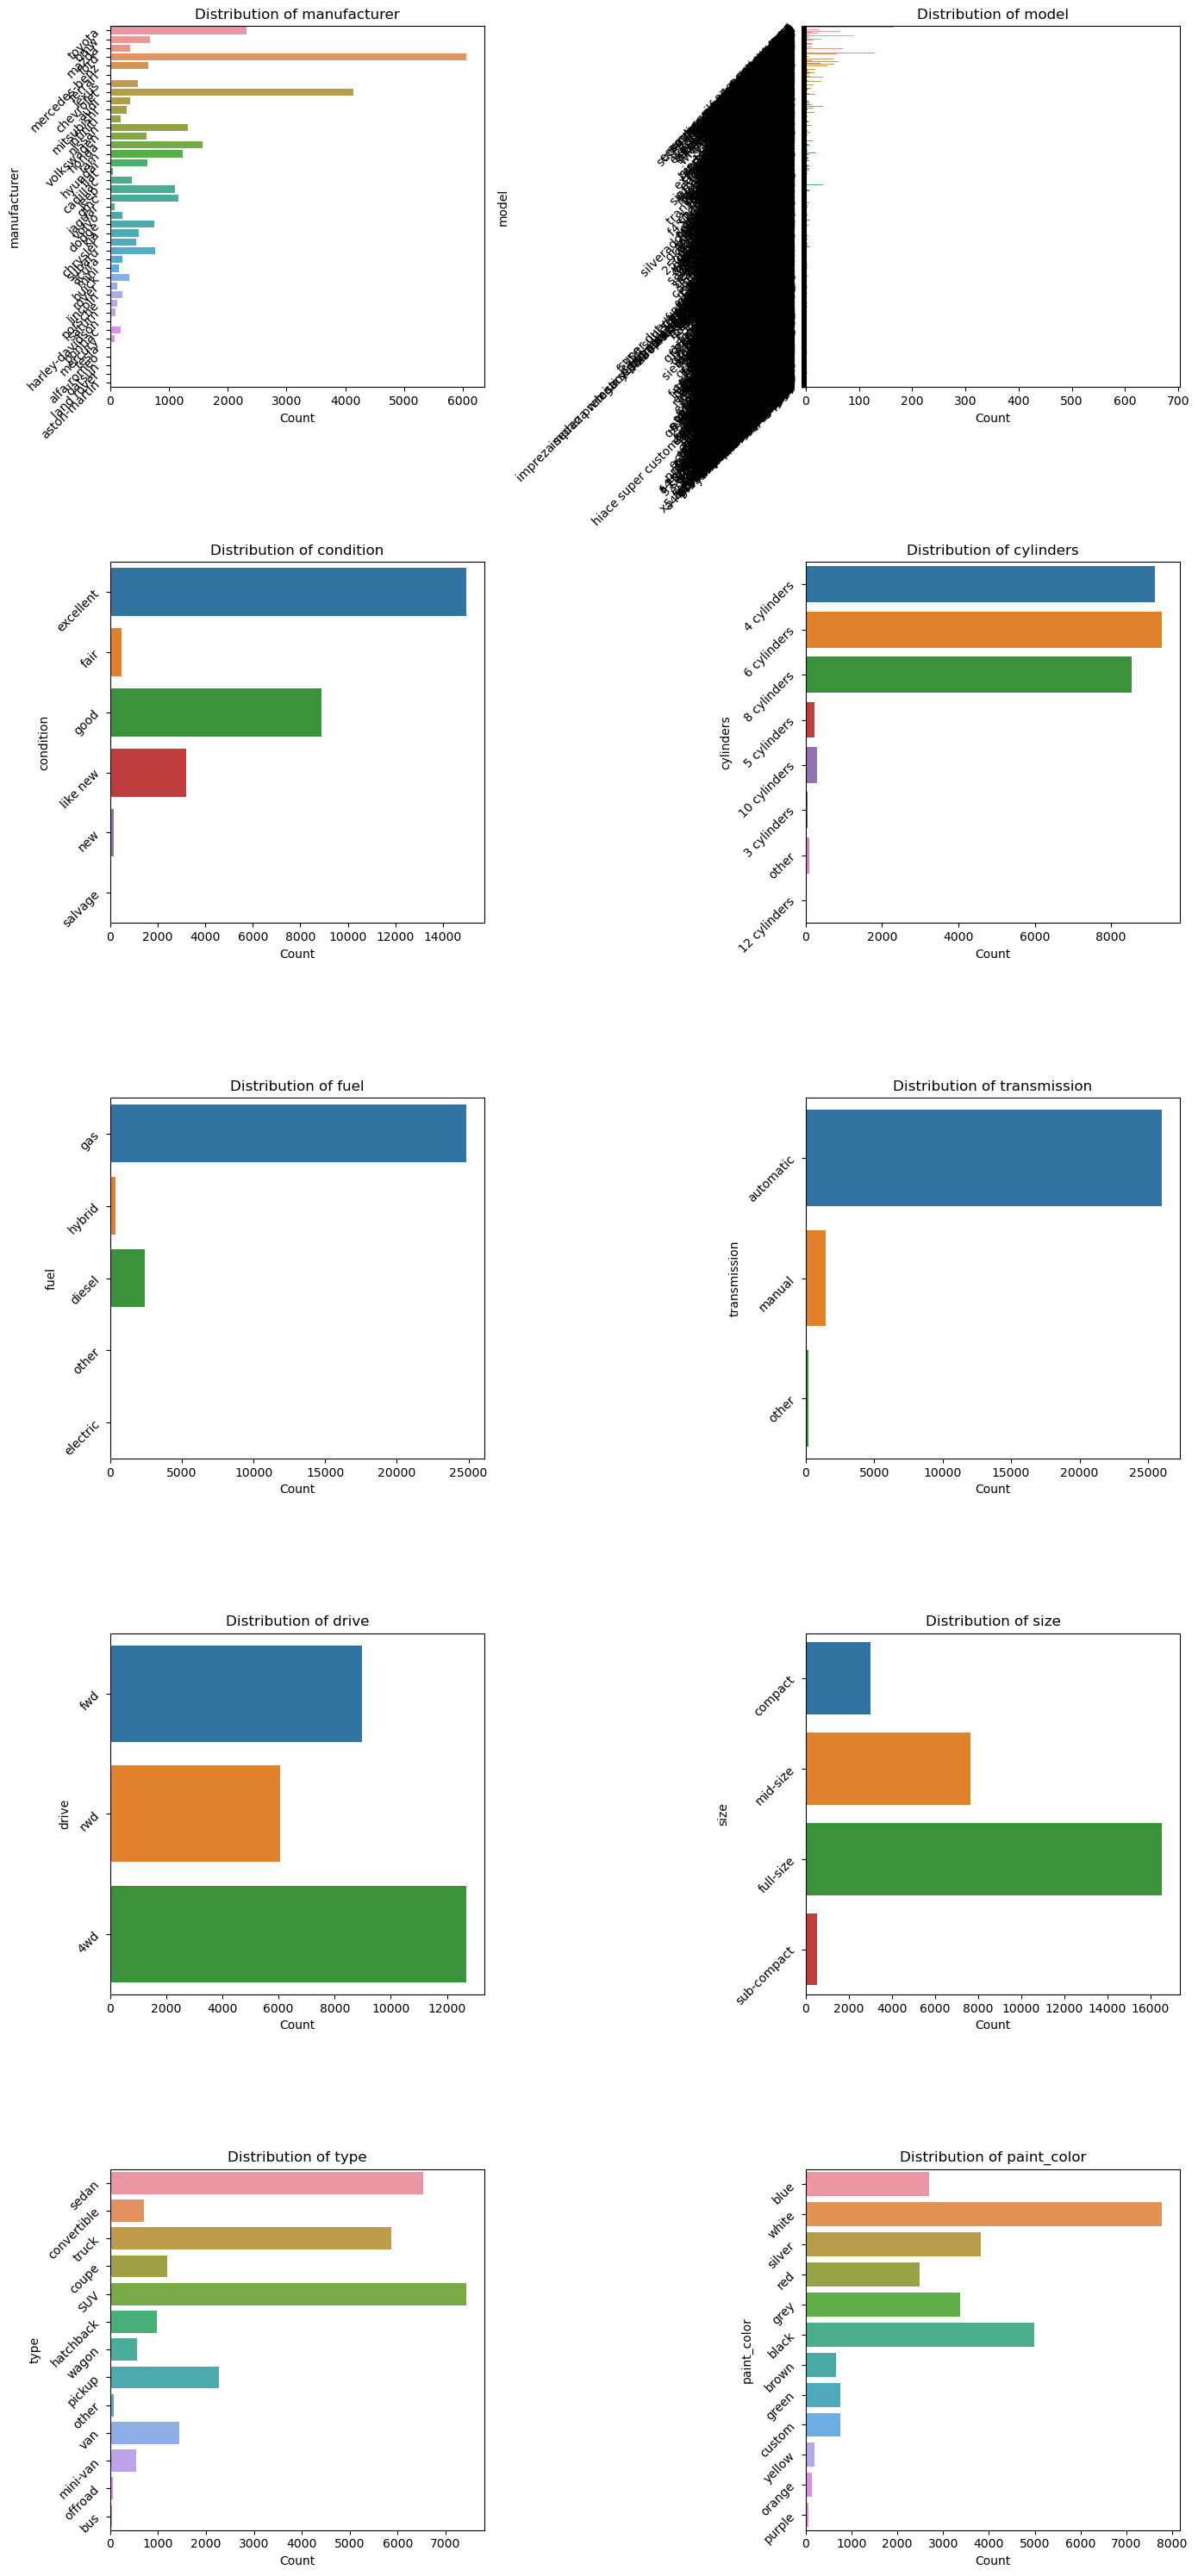

In [221]:
#Visualizations for Categorical Car Features 
categorical_cols = vehicle_df.select_dtypes(include=['object']).columns
num_categorical_cols = len(categorical_cols)

fig, axes = plt.subplots(nrows=(num_categorical_cols + 1) // 2, ncols=2, figsize=(14, num_categorical_cols * 3))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(y=col, data=vehicle_df, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(col)
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].tick_params(axis='y', rotation=45)

plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


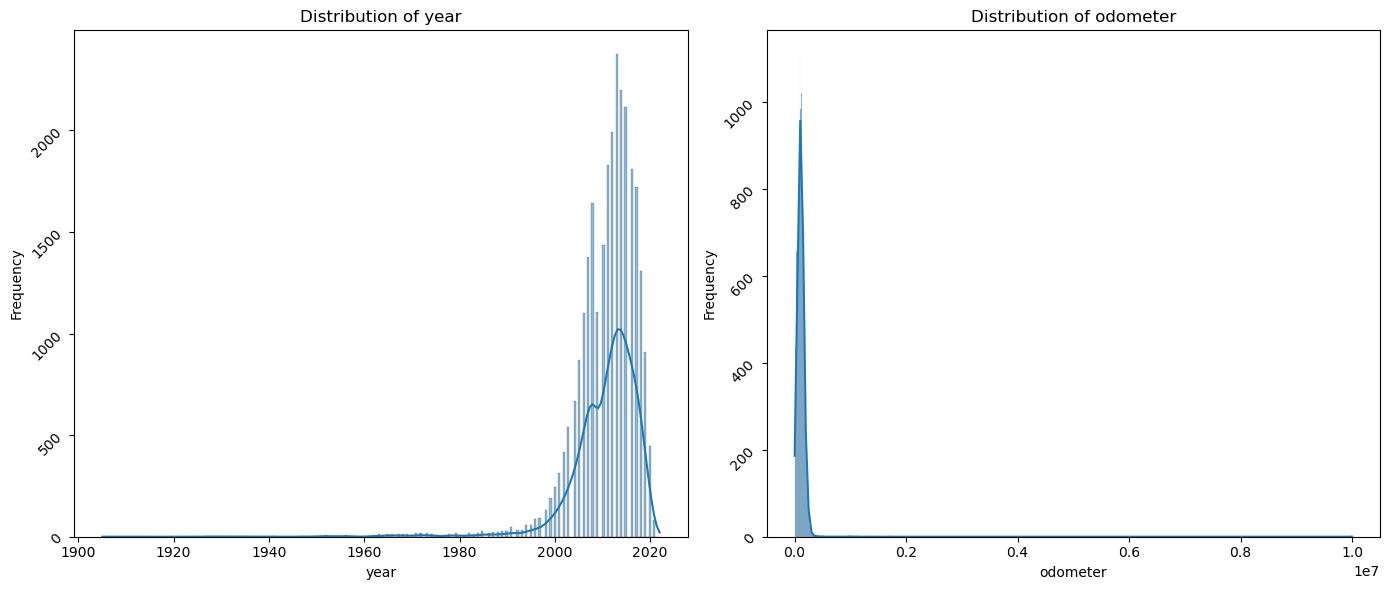

In [222]:
# Visualizations for Numerical Car Features 
numerical_cols = vehicle_df.select_dtypes(include=['float64', 'int64']).columns.drop('price')
num_numerical_cols = len(numerical_cols)

fig, axes = plt.subplots(nrows=(num_numerical_cols + 1) // 2, ncols=2, figsize=(14, num_numerical_cols * 3))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(vehicle_df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].tick_params(axis='y', rotation=45)

plt.tight_layout()
plt.show()

In [223]:
# Define numerical-cols and categorical_cols variables
numerical_cols = vehicle_df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = vehicle_df.select_dtypes(include=['object']).columns

In [224]:
# Fill in the missing values 
vehicle_df[numerical_cols] = vehicle_df[numerical_cols].fillna(vehicle_df[numerical_cols].median())
vehicle_df[categorical_cols] = vehicle_df[categorical_cols].fillna(vehicle_df[categorical_cols].mode().iloc[0])

In [225]:
# Encode categorical columns using LabelEncoder
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    vehicle_df[col] = le.fit_transform(vehicle_df[col])
    label_encoders[col] = le

In [226]:
# Define features (X) and target variable (y)
X = vehicle_df.drop(columns=['price'])
y = vehicle_df['price']

In [227]:
#Verify Variables Were Properly Encoded And Are Numerical Now
X.info()
#y.info()


<class 'pandas.core.frame.DataFrame'>
Index: 27726 entries, 215 to 426833
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          27726 non-null  float64
 1   manufacturer  27726 non-null  int64  
 2   model         27726 non-null  int64  
 3   condition     27726 non-null  int64  
 4   cylinders     27726 non-null  int64  
 5   fuel          27726 non-null  int64  
 6   odometer      27726 non-null  float64
 7   transmission  27726 non-null  int64  
 8   drive         27726 non-null  int64  
 9   size          27726 non-null  int64  
 10  type          27726 non-null  int64  
 11  paint_color   27726 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 2.7 MB


In [228]:
#Verify that there are no more missing values
missing_values_X = X.isnull().sum()
print(f"Missing values:\n{missing_values_X}")
#missing_values_y = y.isnull().sum()
#print(f"Missing values:\n{missing_values_y}")

Missing values:
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
transmission    0
drive           0
size            0
type            0
paint_color     0
dtype: int64


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


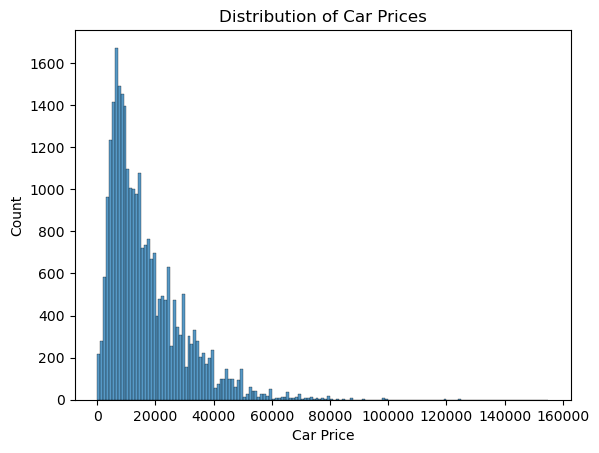

In [189]:
#Check to see if target variable has to be transformed by plotting distribution of Car Prices.
sns.histplot(y, kde=False)  # Set kde=False for a count histogram
plt.xlabel('Car Price')
plt.ylabel('Count')
plt.title('Distribution of Car Prices')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


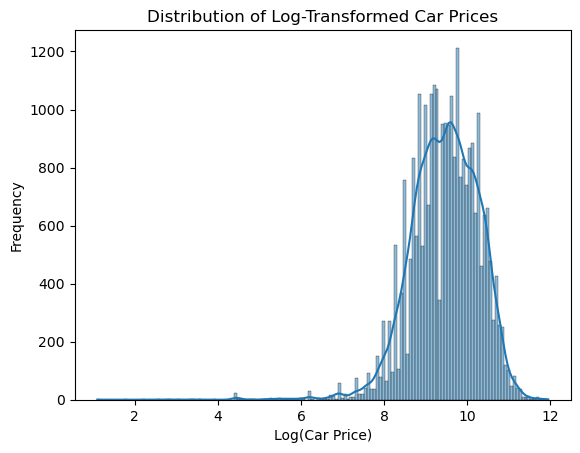

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


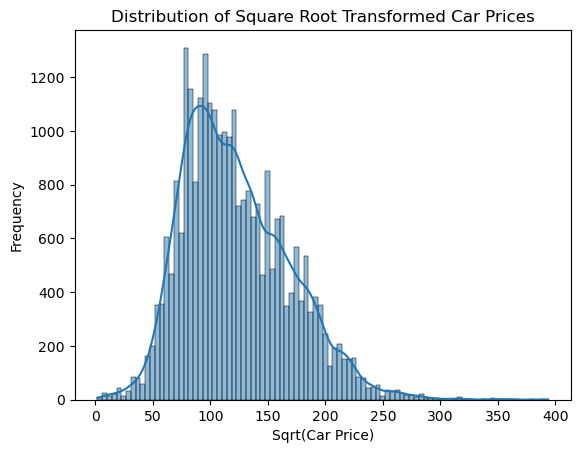

In [190]:
#Since Distribution is skewed to the right must attempt to transform data to achieve a more normal distribution.

#Transformation of y using Logarithm and Accompanying Graph
y_log = np.log(y)
sns.histplot(y_log, kde=True)
plt.xlabel('Log(Car Price)')
plt.ylabel('Frequency')
plt.title('Distribution of Log-Transformed Car Prices')
plt.show()

#Transformation of y using Sqrt and Accompanying Graph
y_sqrt = np.sqrt(y)
sns.histplot(y_sqrt, kde=True)
plt.xlabel('Sqrt(Car Price)')
plt.ylabel('Frequency')
plt.title('Distribution of Square Root Transformed Car Prices')
plt.show()



In [191]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_original, y_test_original = train_test_split(X, y, test_size=0.2, random_state=42)

# Logarithmic Transformation
y_train_log = np.log1p(y_train_original)
y_test_log = np.log1p(y_test_original)

# Square Root Transformation
y_train_sqrt = np.sqrt(y_train_original)
y_test_sqrt = np.sqrt(y_test_original)


# Logarithmic Transformation
model_log = LinearRegression()
model_log.fit(X_train, y_train_log)
r2_log = r2_score(y_test_log, model_log.predict(X_test))
print("R-squared (Logarithmic):", r2_log)

# Square Root Transformation
model_sqrt = LinearRegression()
model_sqrt.fit(X_train, y_train_sqrt)
r2_sqrt = r2_score(y_test_sqrt, model_sqrt.predict(X_test))
print("R-squared (Square Root):", r2_sqrt)



R-squared (Logarithmic): 0.29309042863911405
R-squared (Square Root): 0.34441019547809393


In [192]:
# Use sqrt to transform price column because higher R-Sqared value and to get rid of positive skew. 
vehicle_df['price_sqrt'] = np.sqrt(vehicle_df['price'])

In [193]:
#Check Data Again
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27726 entries, 215 to 426833
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         27726 non-null  int64  
 1   year          27726 non-null  float64
 2   manufacturer  27726 non-null  int64  
 3   model         27726 non-null  int64  
 4   condition     27726 non-null  int64  
 5   cylinders     27726 non-null  int64  
 6   fuel          27726 non-null  int64  
 7   odometer      27726 non-null  float64
 8   transmission  27726 non-null  int64  
 9   drive         27726 non-null  int64  
 10  size          27726 non-null  int64  
 11  type          27726 non-null  int64  
 12  paint_color   27726 non-null  int64  
 13  price_sqrt    27726 non-null  float64
dtypes: float64(3), int64(11)
memory usage: 3.2 MB


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [194]:
#Reassign Variables
X = vehicle_df.drop(columns=['price', 'price_sqrt'])
y = vehicle_df['price_sqrt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [195]:
#Perform VIF To Check For Colinearity
def vif(exogs, data):
    vif_dict = {}

    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = data[not_exog], data[exog]

        r_squared = LinearRegression().fit(X, y).score(X,y)

        vif = 1/(1-r_squared)
        vif_dict[exog] = vif

    return pd.DataFrame({'VIF':vif_dict})

In [196]:
#Display Table of VIF Values
vif(X.columns, X).sort_values(by = 'VIF', ascending= False)

,VIF
cylinders,1.184372
year,1.168805
drive,1.157222
type,1.138135
fuel,1.131371
manufacturer,1.074532
transmission,1.061061
odometer,1.047529
paint_color,1.038330
model,1.032465


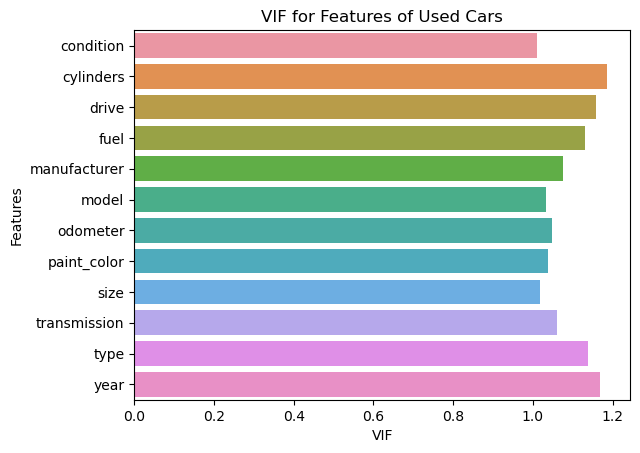

In [197]:
#VIF Graph for features of used cars.

vif_df = vif(X.columns, X)
sns.barplot(x = 'VIF', y = vif_df.index, data = vif_df)
plt.xlabel('VIF')
plt.ylabel('Features')
plt.title('VIF for Features of Used Cars')
plt.show()


In [198]:
#Evaluate the Different Model Types To Find Best Model Type To Use
# Define models
models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge()
}

# Evaluate models using cross-validation
cv_results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    cv_results[name] = -cv_scores.mean()
    print(f"{name} - CV Mean Squared Error: {-cv_scores.mean()}")

LinearRegression - CV Mean Squared Error: 1402.7303037414142
Lasso - CV Mean Squared Error: 1419.0093762947715
Ridge - CV Mean Squared Error: 1402.7304609839614


In [199]:

lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)

# Predict on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model
lrmse = mean_squared_error(y_test, y_pred)
lr2 = r2_score(y_test, y_pred)

print(f'Linear Regression - Mean Squared Error (MSE): {lrmse}')
print(f'Linear Regression - R-squared (R2): {lr2}')

r = permutation_importance(lr_model, X_test, y_test, random_state=42)
importances_df = pd.DataFrame(r.importances_mean, index=X_test.columns, columns=['importance'])
importances_df.sort_values(by='importance', ascending=False)


Linear Regression - Mean Squared Error (MSE): 1411.9385264827747
Linear Regression - R-squared (R2): 0.34441019547809393


,importance
year,0.245931
fuel,0.188456
cylinders,0.180970
odometer,0.140772
transmission,0.012075
drive,0.009930
paint_color,0.002826
type,0.002648
size,0.001679
manufacturer,0.000830


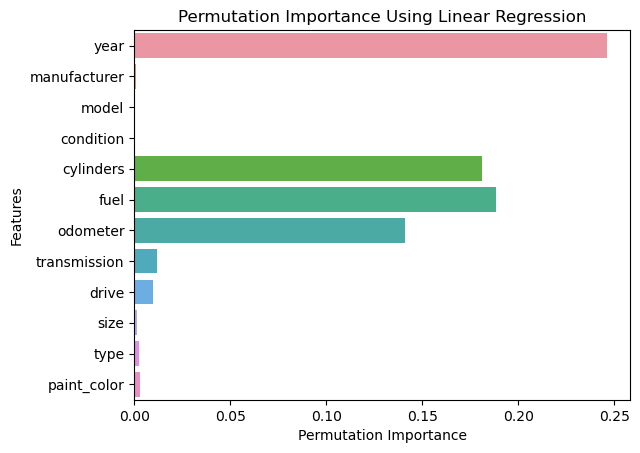

In [200]:
# prompt: Want To Graph Permutation Importance Using sns

import matplotlib.pyplot as plt
sns.barplot(x='importance', y=importances_df.index, data=importances_df)
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Permutation Importance Using Linear Regression')
plt.show()


In [201]:
# Define Lasso model and perform grid search for hyperparameter tuning
lasso = Lasso(max_iter=100)
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}
grid_search = GridSearchCV(lasso, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_lasso_model = grid_search.best_estimator_
print(f"Best Lasso Parameters: {grid_search.best_params_}")

# Fit the best model
best_lasso_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_lasso_model.predict(X_test)

# Evaluate the model
Lassomse = mean_squared_error(y_test, y_pred)
Lassor2 = r2_score(y_test, y_pred)

print(f'Best Lasso - Mean Squared Error (MSE): {Lassomse}')
print(f'Best Lasso - R-squared (R2): {Lassor2}')


/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Lasso Parameters: {'alpha': 0.01}
Best Lasso - Mean Squared Error (MSE): 1411.9731165537971
Best Lasso - R-squared (R2): 0.3443941346528706


         feature  importance_mean
0           year         0.234563
5           fuel         0.187342
4      cylinders         0.183818
6       odometer         0.143775
7   transmission         0.011383
8          drive         0.010048
11   paint_color         0.002393
10          type         0.002317
9           size         0.001363
1   manufacturer         0.000818
2          model         0.000746
3      condition         0.000486


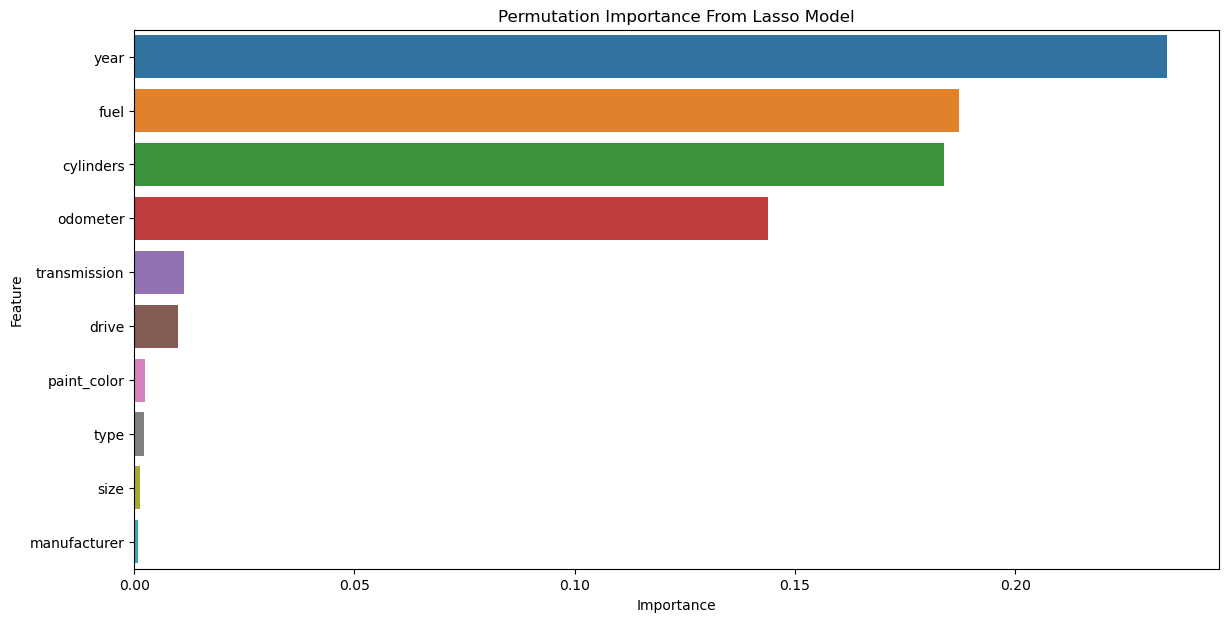

In [202]:
# Compute permutation importance
perm_importance = permutation_importance(best_lasso_model, X_test, y_test, n_repeats=30, random_state=42)

# Create DataFrame for Permutation Importance results
perm_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_importance.importances_mean,
})

# Sort the DataFrame by Permuation Importance
perm_df = perm_df.sort_values(by='importance_mean', ascending=False)

print(perm_df)

# Visualize the Permutation Importance Resulting From Lasso 
plt.figure(figsize=(14, 7))
sns.barplot(x='importance_mean', y='feature', data=perm_df.head(10))
plt.title('Permutation Importance From Lasso Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [203]:
# Define Ridge model and utilize grid search for hyperparameter tuning
ridge = Ridge(max_iter=100)
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}
grid_search = GridSearchCV(ridge, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_ridge_model = grid_search.best_estimator_
print(f"Best Ridge Parameters: {grid_search.best_params_}")

# Fit the best model
best_ridge_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_ridge_model.predict(X_test)

# Evaluate the model
Ridgemse = mean_squared_error(y_test, y_pred)
Ridger2 = r2_score(y_test, y_pred)

print(f'Ridge - Mean Squared Error (MSE): {Ridgemse}')
print(f'Ridge - R-squared (R2): {Ridger2}')


Best Ridge Parameters: {'alpha': 0.01}
Ridge - Mean Squared Error (MSE): 1411.9385364349982
Ridge - R-squared (R2): 0.344410190857088


         feature  importance_mean
0           year         0.234749
5           fuel         0.187436
4      cylinders         0.183900
6       odometer         0.143793
7   transmission         0.011527
8          drive         0.010094
11   paint_color         0.002398
10          type         0.002313
9           size         0.001371
1   manufacturer         0.000821
2          model         0.000743
3      condition         0.000490


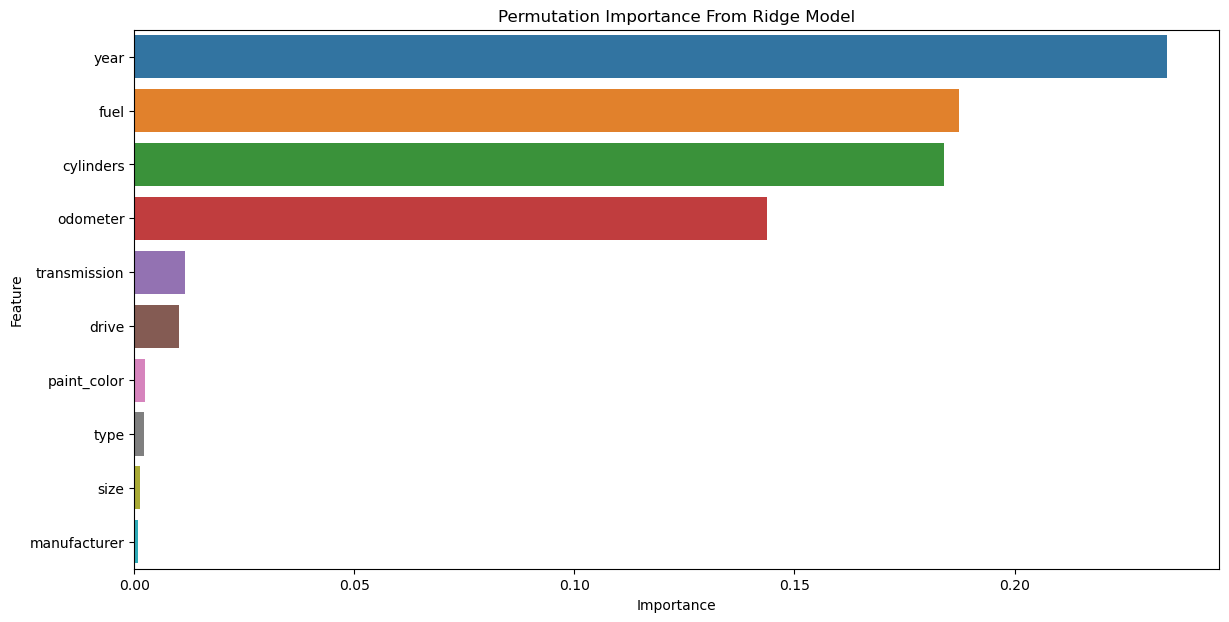

In [204]:
# Compute permutation importance
perm_importance = permutation_importance(best_ridge_model, X_test, y_test, n_repeats=30, random_state=42)

# Create DataFrame for Permutation Importance results
perm_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_importance.importances_mean,
})

# Sort the DataFrame by Permuation Importance
perm_df = perm_df.sort_values(by='importance_mean', ascending=False)

print(perm_df)

# Visualize the Permutation Importance Resulting From Ridge Model
plt.figure(figsize=(14, 7))
sns.barplot(x='importance_mean', y='feature', data=perm_df.head(10))
plt.title('Permutation Importance From Ridge Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [207]:
#Print MSE  of Linear Regression Model 
print(f'Linear Regression - Mean Squared Error (MSE): {lrmse}')
print(f'Linear Regression - R-squared (R2): {lr2}')

#Print MSE  Value of Lasso Model 
print(f'Best Lasso - Mean Squared Error (MSE): {Lassomse}')
print(f'Best Lasso - R-squared (R2): {Lassor2}')


#Print MSE  Value of Ridge Model 
print(f'Ridge - Mean Squared Error (MSE): {Ridgemse}')
print(f'Ridge - R-squared (R2): {Ridger2}')


#Evaluate the Different Model Types To Find Best Model Type To Use
# Define models
models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge()
}

# Evaluate models using cross-validation
cv_results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    cv_results[name] = -cv_scores.mean()
    print(f"{name} - CV Mean Squared Error: {-cv_scores.mean()}")




Linear Regression - Mean Squared Error (MSE): 1411.9385264827747
Linear Regression - R-squared (R2): 0.34441019547809393
Best Lasso - Mean Squared Error (MSE): 1411.9731165537971
Best Lasso - R-squared (R2): 0.3443941346528706
Ridge - Mean Squared Error (MSE): 1411.9385364349982
Ridge - R-squared (R2): 0.344410190857088
LinearRegression - CV Mean Squared Error: 1402.7303037414142
Lasso - CV Mean Squared Error: 1419.0093762947715
Ridge - CV Mean Squared Error: 1402.7304609839614


From the cell above we get the Mean Squared Error (MSE) of all three models using the test set as well as the Cross Validation Mean Squared Error (CV MSE) for the three different models: Linear Regression, Lasso, and Ridge.  From this it is evident that the MSE for both Linear Regression and Ridge are both higher than those models respective CV MSE.  This can be an indicator of overfitting which can suggest that maybe the Lasso model would be better to use to model this data.  Furthermore, the Lasso MSE and and CV MSE are closer together than the other two models and the MSE is lower than the CV MSE.  Finally, the r squared value is 0.344 for this model so that means that model shows that the features do have atleast a moderate correlation to the price of used cars.  This means that we can use the permutation importance from the Lasso model to determine which features are most important to consumers. 

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

The model that was produced has a r-squared value of 0.34 which means that the features of used car had a moderate correlation with the price of the car.  What this means is that the features that were included in the model do in fact have an impact on the price of the car.  The features that were included in the model were: year, fuel type, number of cylinders in the engine, miles on odometer, transmission, type of drive (rear wheel drive, all wheel drive, etc.), color, type of vehicle, size, manufacturer, model of vehicle, and condition of the vehicle. When fine tuning inventory it is important to be most aware of the year of the car, the type of fuel the car uses, how many cylinders are present in the engine, and how many miles are on the odometer in that order because these are the features that impacted price the most.  This suggests that these features are what customers most value in their vehicles.  Suggested next step for used car dealerships would be to look at which year, what type of fuel, how many cylinders are present in the engine, and how many miles are on the cars that sell for high prices so that they can best guage what cars to keep in or add to inventory because those will attract buyers utlimately resulting in profit for the used car dealership. 